In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm
from sklearn import datasets

In [3]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.res_flow as irf

In [4]:
# np.random.seed(249)
# xx, y = datasets.make_circles(n_samples=300, factor=0.5, noise=0.05)
# x_ = np.random.randn(100, 2)*0.1
# xx = np.concatenate([xx, x_], axis=0)
# y = np.concatenate([y, np.ones(len(x_), dtype=int)*0])

In [5]:
np.random.seed(249) ## 148, 249

xxc, yc = datasets.make_circles(n_samples=265, factor=.5,
                                      noise=.07)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = datasets.make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

In [6]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([100, 100, 100]))

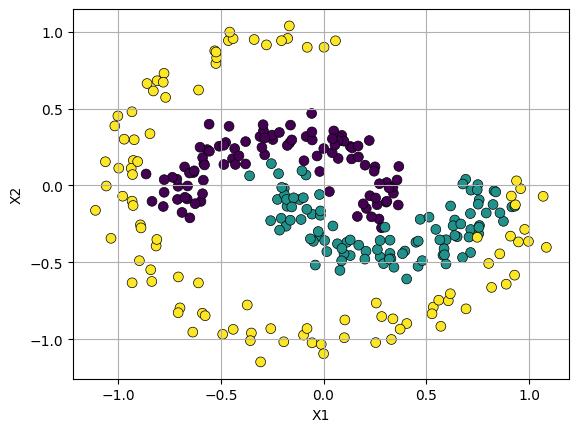

In [7]:
## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
# x1 = (x1-x1.min())/(x1.max()-x1.min())
# x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

xx = torch.Tensor(xx)
yy = torch.Tensor(y.reshape(-1, 1))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

# (x1min, x1max) = -0.1, 1.1
# plt.xlim((x1min, x1max))
# plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [8]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         init_val = torch.ones(num_sets, output_dim)/output_dim

        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 1.
        self.cls_weight = nn.Parameter(init_val.abs())

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data.abs_()
#         self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
#         c = self.cls_weight
        c = torch.softmax(self.cls_weight, dim=1)
        return x@c

In [9]:
# class LeakySignum(nn.Module):
#     def forward(self, x):
#         x=x+0.5
#         o1x = 0.1*x
#         return torch.minimum(torch.maximum(x, o1x*0.0), o1x+0.9)

In [10]:
class LeakyRectFilter(nn.Module):
    def forward(self, x):
        x = x.abs()
#         return -torch.maximum(torch.minimum(0.1*x-0.15, x-1.5), 0.1*x-1.05)
        return -torch.maximum(torch.minimum(0.01*(x-1.5), x-1.5), 0.1*x-1.05)

## Train, non-softmax based classifier


In [11]:
#### if we use same distance scaler, then same always increasing function, we get same argmax db

In [12]:
class LeakySignum(nn.Module):
    def forward(self, x):
        o1x = 0.1*x
        return torch.minimum(torch.maximum(x, o1x), o1x+0.9)

In [13]:
class DistanceBinaryClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        self.actf = nn.Sigmoid()
#         self.actf = LeakySignum()
#         self.actf = LeakyRectFilter()
        self.pos_val = nn.Parameter(torch.ones(1, output_dim)*0.5)
        self.neg_val = nn.Parameter(torch.ones(1, output_dim)*0.5)
        
    def forward(self, x, hard=False):
        self.pos_val.data.abs_()
        self.pos_val.data = self.pos_val.data/self.pos_val.data.sum()
        self.neg_val.data.abs_()
        self.neg_val.data = self.neg_val.data/self.neg_val.data.sum()
        
        x = torch.norm(x-self.centers, dim=1, keepdim=True) + self.bias
        if hard:
            x = torch.sigmoid(-x*1e5)
        else:
            x = self.actf(-x*self.inv_temp)
        x = x*self.pos_val + (1-x)*self.neg_val
        return x

In [14]:
class DistanceMulticlassClassifier(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1, num_sets)*-1)
        self.inv_temp = nn.Parameter(torch.ones(1, num_sets)*inv_temp)
        
#         init_val = torch.ones(num_sets, output_dim)/output_dim
        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 1.
        self.cls_weight = nn.Parameter(init_val.abs())

        self.cls_confidence = None
        self.dist_loss = 0
        
#         self.actf = nn.Sigmoid()
        self.actf = LeakySignum()
#         self.actf = LeakyRectFilter()
        
    def forward(self, x, hard=False):
#         self.cls_weight.data.abs_()
#         self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
#         dists = dists*self.inv_temp + self.bias
        dists = dists + self.bias

#         if hard:
        dists = self.actf(-dists)
        indices = torch.argmax(dists, dim=1)
        c = torch.softmax(self.cls_weight, dim=1)

        probs = c[indices]
        scaler = dists[torch.arange(len(indices), dtype=torch.long), indices]
#         print(scaler)
#         print(probs)

#         x = torch.softmax(dists, dim=1)
        y = probs*scaler.reshape(-1, 1)
    
        self.cls_confidence = scaler.data
#         self.dist_loss = -torch.cdist(x, self.centers).mean()
#         return x@c
        return y

In [15]:
dmc = DistanceMulticlassClassifier(2, 5, 3)

In [16]:
dmc(torch.randn(10, 2))

tensor([[ 0.2214,  0.0970,  0.0890],
        [ 0.3619,  0.1356,  0.1497],
        [ 0.3967,  0.1486,  0.1642],
        [ 0.2319,  0.1016,  0.0932],
        [ 0.1077,  0.1151,  0.2899],
        [ 0.0839,  0.0896,  0.2258],
        [ 0.0814,  0.1915,  0.0804],
        [-0.0098, -0.0104, -0.0263],
        [ 0.5183,  0.1942,  0.2145],
        [ 0.3979,  0.1491,  0.1646]], grad_fn=<MulBackward0>)

In [17]:
dmc.cls_confidence

tensor([ 0.4073,  0.6472,  0.7095,  0.4266,  0.5127,  0.3994,  0.3533, -0.0465,
         0.9270,  0.7116])

In [18]:
ycls = yy.reshape(-1).type(torch.long)

ycls_ = torch.zeros(len(ycls), ycls.max()+1)
ycls_[torch.arange(0, len(ycls), dtype=torch.long), ycls] = 1.

In [19]:
# ycls_, ycls

In [20]:
# model = nn.Sequential(nn.Linear(2, 10, bias=False),
# #                       nn.BatchNorm1d(10),
#                       nn.SELU(),
#                       nn.Linear(10, 2, bias=False),
# #                       nn.BatchNorm1d(2),
#                       nn.SELU(),
#                      )

In [21]:
actf = irf.Swish
# actf = irf.ReLU
flows = [
    ActNorm(2),
    irf.ResidualFlow(2, [20], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [20], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [20], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [20], activation=actf),
    ActNorm(2),
        ]

model = nn.Sequential(*flows)

In [22]:
# classifier = ConnectedClassifier_SoftKMeans(2, 5, ycls.max().item()+1, inv_temp=1)
# classifier = DistanceBinaryClassifier(2, ycls.max().item()+1, inv_temp=1)
classifier = DistanceMulticlassClassifier(2, 5, ycls.max().item()+1)

In [23]:
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=0.001)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  432


In [24]:
%matplotlib tk
fig = plt.figure(figsize=(12, 6))
ax, ax_ = fig.subplots(1, 2)

model.train()
losses = []
NUM = 512

### for plotting in 2d grid
ng = 400
# _a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
s = 1.0
_a,_b,_c,_d = x1.min()-s, x1.max()+s, x2.min()-s, x2.max()+s
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

for epoch in tqdm(range(1000*10+1)):
    optimizer.zero_grad()
    
    z = model(xx)
    yout = classifier(z)
    
    loss = criterion(yout, ycls_) #+ classifier.dist_loss*0.001
#     loss = criterion(yout, ycls)
    loss.backward()
    optimizer.step()
        
    if epoch%100 == 0:
        acc = (yout.data.argmax(dim=1) == ycls)
        acc = float(acc.type(torch.float32).mean())
        losses.append(float(loss))
        print(f"Epoch: {epoch} Loss: {losses[-1]} Accuracy: {acc}")

        ax.clear(); ax_.clear()
        with torch.no_grad():
            z = model(xx)
            yout = classifier(z)
            
        yout_img = classifier(model(xyg))
        out = yout_img.data.argmax(dim=1).numpy()
#         out = yout_img.data[torch.arange(0, len(out), dtype=torch.long), out.reshape(-1)].numpy()

        cf = ax.contourf(xg, yg, out.reshape(xg.shape),# v,
                         alpha=0.5, antialiased=True)

        cf = ax_.contourf(xg, yg, classifier.cls_confidence.reshape(xg.shape),
                         alpha=0.5, antialiased=True, levels=15)
        ax.grid()

        ax_.scatter(x1, x2, c=ycls.numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=ycls.numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
#         ax.scatter(x1, x2, c=yout.data.argmax(dim=1).numpy().reshape(-1), marker='.')
            
        fig.canvas.draw()
        plt.savefig("./invex_out/MultiInvex_OOD_3moons.pdf")
        plt.pause(0.01)
# plt.close()

  0%|                                                           | 0/10001 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.2780319154262543 Accuracy: 0.23333333432674408


  1%|▎                                                | 73/10001 [00:00<00:50, 198.09it/s]

Epoch: 100 Loss: 0.21996647119522095 Accuracy: 0.39666667580604553


  2%|▊                                               | 173/10001 [00:01<00:44, 220.72it/s]

Epoch: 200 Loss: 0.21041126549243927 Accuracy: 0.4266666769981384


  3%|█▎                                              | 274/10001 [00:01<00:42, 226.44it/s]

Epoch: 300 Loss: 0.2033241093158722 Accuracy: 0.4399999976158142


  4%|█▊                                              | 378/10001 [00:02<00:41, 232.60it/s]

Epoch: 400 Loss: 0.18725982308387756 Accuracy: 0.4633333384990692


  5%|██▎                                             | 481/10001 [00:02<00:40, 233.95it/s]

Epoch: 500 Loss: 0.16557881236076355 Accuracy: 0.7133333086967468


  6%|██▊                                             | 585/10001 [00:03<00:39, 236.79it/s]

Epoch: 600 Loss: 0.1525428146123886 Accuracy: 0.7099999785423279


  7%|███▎                                            | 690/10001 [00:03<00:39, 238.61it/s]

Epoch: 700 Loss: 0.14122916758060455 Accuracy: 0.7200000286102295


  8%|███▊                                            | 795/10001 [00:04<00:38, 239.32it/s]

Epoch: 800 Loss: 0.13324758410453796 Accuracy: 0.7266666889190674


  9%|████▎                                           | 900/10001 [00:04<00:37, 239.74it/s]

Epoch: 900 Loss: 0.12930533289909363 Accuracy: 0.7099999785423279


 10%|████▋                                           | 967/10001 [00:05<00:43, 206.78it/s]

Epoch: 1000 Loss: 0.11134336143732071 Accuracy: 0.8133333325386047


 11%|█████                                          | 1072/10001 [00:05<00:39, 224.90it/s]

Epoch: 1100 Loss: 0.10069207847118378 Accuracy: 0.8233333230018616


 12%|█████▌                                         | 1175/10001 [00:06<00:37, 233.39it/s]

Epoch: 1200 Loss: 0.10084464401006699 Accuracy: 0.8199999928474426


 13%|██████                                         | 1277/10001 [00:06<00:37, 232.28it/s]

Epoch: 1300 Loss: 0.10017916560173035 Accuracy: 0.8166666626930237


 14%|██████▍                                        | 1381/10001 [00:07<00:36, 233.85it/s]

Epoch: 1400 Loss: 0.09543214738368988 Accuracy: 0.8233333230018616


 15%|██████▉                                        | 1486/10001 [00:07<00:38, 223.98it/s]

Epoch: 1500 Loss: 0.09747669100761414 Accuracy: 0.8133333325386047


 16%|███████▍                                       | 1591/10001 [00:08<00:36, 232.97it/s]

Epoch: 1600 Loss: 0.09873081743717194 Accuracy: 0.8100000023841858


 17%|███████▉                                       | 1696/10001 [00:08<00:35, 233.66it/s]

Epoch: 1700 Loss: 0.09322988986968994 Accuracy: 0.8266666531562805


 18%|████████▎                                      | 1764/10001 [00:09<00:40, 204.31it/s]

Epoch: 1800 Loss: 0.08540418744087219 Accuracy: 0.8433333039283752


 19%|████████▊                                      | 1874/10001 [00:09<00:35, 225.93it/s]

Epoch: 1900 Loss: 0.0866553783416748 Accuracy: 0.8433333039283752


 20%|█████████▎                                     | 1977/10001 [00:10<00:34, 231.93it/s]

Epoch: 2000 Loss: 0.08651146292686462 Accuracy: 0.8399999737739563


 21%|█████████▊                                     | 2078/10001 [00:10<00:34, 231.78it/s]

Epoch: 2100 Loss: 0.08600978553295135 Accuracy: 0.8433333039283752


 22%|██████████▏                                    | 2180/10001 [00:11<00:33, 234.56it/s]

Epoch: 2200 Loss: 0.07995544373989105 Accuracy: 0.8533333539962769


 23%|██████████▋                                    | 2283/10001 [00:11<00:32, 237.57it/s]

Epoch: 2300 Loss: 0.08510296791791916 Accuracy: 0.8433333039283752


 24%|███████████▏                                   | 2386/10001 [00:12<00:31, 239.01it/s]

Epoch: 2400 Loss: 0.08830641210079193 Accuracy: 0.8366666436195374


 25%|███████████▋                                   | 2490/10001 [00:12<00:31, 240.63it/s]

Epoch: 2500 Loss: 0.0931042805314064 Accuracy: 0.8299999833106995


 26%|████████████▏                                  | 2594/10001 [00:13<00:30, 240.60it/s]

Epoch: 2600 Loss: 0.10985037684440613 Accuracy: 0.7900000214576721


 27%|████████████▋                                  | 2696/10001 [00:13<00:31, 233.41it/s]

Epoch: 2700 Loss: 0.11613620817661285 Accuracy: 0.7900000214576721


 28%|█████████████▏                                 | 2800/10001 [00:14<00:30, 239.50it/s]

Epoch: 2800 Loss: 0.08244138211011887 Accuracy: 0.8500000238418579


 29%|█████████████▍                                 | 2868/10001 [00:14<00:34, 209.29it/s]

Epoch: 2900 Loss: 0.07682862877845764 Accuracy: 0.8600000143051147


 30%|█████████████▉                                 | 2973/10001 [00:15<00:30, 227.97it/s]

Epoch: 3000 Loss: 0.07533594965934753 Accuracy: 0.8666666746139526


 31%|██████████████▍                                | 3075/10001 [00:15<00:29, 233.94it/s]

Epoch: 3100 Loss: 0.07468456774950027 Accuracy: 0.8666666746139526


 32%|██████████████▉                                | 3179/10001 [00:16<00:28, 237.33it/s]

Epoch: 3200 Loss: 0.046736374497413635 Accuracy: 0.9233333468437195


 33%|███████████████▍                               | 3283/10001 [00:16<00:28, 238.56it/s]

Epoch: 3300 Loss: 0.03563222661614418 Accuracy: 0.9433333277702332


 34%|███████████████▉                               | 3386/10001 [00:17<00:27, 237.15it/s]

Epoch: 3400 Loss: 0.02700241468846798 Accuracy: 0.9566666483879089


 35%|████████████████▍                              | 3489/10001 [00:17<00:27, 235.57it/s]

Epoch: 3500 Loss: 0.02691970393061638 Accuracy: 0.9566666483879089


 36%|████████████████▊                              | 3590/10001 [00:18<00:29, 220.16it/s]

Epoch: 3600 Loss: 0.02456815168261528 Accuracy: 0.9599999785423279


 37%|█████████████████▎                             | 3694/10001 [00:18<00:27, 230.47it/s]

Epoch: 3700 Loss: 0.02614728920161724 Accuracy: 0.9566666483879089


 38%|█████████████████▊                             | 3796/10001 [00:19<00:26, 232.91it/s]

Epoch: 3800 Loss: 0.02185332216322422 Accuracy: 0.9700000286102295


 39%|██████████████████▎                            | 3898/10001 [00:19<00:26, 232.81it/s]

Epoch: 3900 Loss: 0.019875910133123398 Accuracy: 0.9733333587646484


 40%|██████████████████▊                            | 4000/10001 [00:20<00:25, 233.79it/s]

Epoch: 4000 Loss: 0.019981706514954567 Accuracy: 0.9733333587646484


 41%|███████████████████                            | 4067/10001 [00:20<00:28, 205.12it/s]

Epoch: 4100 Loss: 0.021767642349004745 Accuracy: 0.9700000286102295


 42%|███████████████████▌                           | 4174/10001 [00:21<00:25, 227.06it/s]

Epoch: 4200 Loss: 0.01744678243994713 Accuracy: 0.9766666889190674


 43%|████████████████████                           | 4278/10001 [00:21<00:24, 236.10it/s]

Epoch: 4300 Loss: 0.017519136890769005 Accuracy: 0.9766666889190674


 44%|████████████████████▌                          | 4380/10001 [00:22<00:23, 236.55it/s]

Epoch: 4400 Loss: 0.025267235934734344 Accuracy: 0.9633333086967468


 45%|█████████████████████                          | 4483/10001 [00:22<00:23, 234.47it/s]

Epoch: 4500 Loss: 0.017164509743452072 Accuracy: 0.9766666889190674


 46%|█████████████████████▌                         | 4587/10001 [00:23<00:22, 237.02it/s]

Epoch: 4600 Loss: 0.015161009505391121 Accuracy: 0.9800000190734863


 47%|██████████████████████                         | 4691/10001 [00:23<00:22, 237.32it/s]

Epoch: 4700 Loss: 0.018886782228946686 Accuracy: 0.9733333587646484


 48%|██████████████████████▌                        | 4795/10001 [00:24<00:22, 236.51it/s]

Epoch: 4800 Loss: 0.013081779703497887 Accuracy: 0.9833333492279053


 49%|███████████████████████                        | 4899/10001 [00:24<00:21, 236.68it/s]

Epoch: 4900 Loss: 0.016989685595035553 Accuracy: 0.9766666889190674


 50%|███████████████████████▎                       | 4967/10001 [00:25<00:24, 204.67it/s]

Epoch: 5000 Loss: 0.012985369190573692 Accuracy: 0.9833333492279053


 51%|███████████████████████▊                       | 5069/10001 [00:25<00:22, 221.09it/s]

Epoch: 5100 Loss: 0.017076874151825905 Accuracy: 0.9766666889190674


 52%|████████████████████████▎                      | 5174/10001 [00:26<00:20, 232.13it/s]

Epoch: 5200 Loss: 0.014934677630662918 Accuracy: 0.9800000190734863


 53%|████████████████████████▊                      | 5277/10001 [00:26<00:20, 236.11it/s]

Epoch: 5300 Loss: 0.014906106516718864 Accuracy: 0.9800000190734863


 54%|█████████████████████████▎                     | 5381/10001 [00:27<00:19, 238.24it/s]

Epoch: 5400 Loss: 0.01701529696583748 Accuracy: 0.9766666889190674


 55%|█████████████████████████▊                     | 5485/10001 [00:27<00:18, 238.39it/s]

Epoch: 5500 Loss: 0.014780142344534397 Accuracy: 0.9800000190734863


 56%|██████████████████████████▎                    | 5589/10001 [00:28<00:18, 238.43it/s]

Epoch: 5600 Loss: 0.014849248342216015 Accuracy: 0.9800000190734863


 57%|██████████████████████████▊                    | 5694/10001 [00:29<00:19, 226.21it/s]

Epoch: 5700 Loss: 0.01279345154762268 Accuracy: 0.9833333492279053


 58%|███████████████████████████▏                   | 5797/10001 [00:29<00:18, 231.99it/s]

Epoch: 5800 Loss: 0.014682110399007797 Accuracy: 0.9800000190734863


 59%|███████████████████████████▌                   | 5865/10001 [00:29<00:20, 204.46it/s]

Epoch: 5900 Loss: 0.012679105624556541 Accuracy: 0.9833333492279053


 60%|████████████████████████████                   | 5973/10001 [00:30<00:17, 225.17it/s]

Epoch: 6000 Loss: 0.01458090078085661 Accuracy: 0.9800000190734863


 61%|████████████████████████████▌                  | 6075/10001 [00:30<00:17, 230.74it/s]

Epoch: 6100 Loss: 0.01068879198282957 Accuracy: 0.9866666793823242


 62%|█████████████████████████████▏                 | 6199/10001 [00:31<00:16, 229.83it/s]

Epoch: 6200 Loss: 0.012578808702528477 Accuracy: 0.9833333492279053


 63%|█████████████████████████████▌                 | 6299/10001 [00:32<00:16, 229.48it/s]

Epoch: 6300 Loss: 0.00857438426464796 Accuracy: 0.9900000095367432


 64%|██████████████████████████████                 | 6400/10001 [00:32<00:15, 232.29it/s]

Epoch: 6400 Loss: 0.014723509550094604 Accuracy: 0.9800000190734863


 65%|██████████████████████████████▍                | 6465/10001 [00:33<00:17, 196.84it/s]

Epoch: 6500 Loss: 0.008477815426886082 Accuracy: 0.9900000095367432


 66%|██████████████████████████████▉                | 6572/10001 [00:33<00:15, 222.35it/s]

Epoch: 6600 Loss: 0.008457379415631294 Accuracy: 0.9900000095367432


 67%|███████████████████████████████▎               | 6674/10001 [00:34<00:14, 232.43it/s]

Epoch: 6700 Loss: 0.012762189842760563 Accuracy: 0.9833333492279053


 68%|███████████████████████████████▊               | 6778/10001 [00:34<00:13, 235.88it/s]

Epoch: 6800 Loss: 0.008447625674307346 Accuracy: 0.9900000095367432


 69%|████████████████████████████████▎              | 6881/10001 [00:35<00:13, 235.12it/s]

Epoch: 6900 Loss: 0.008419796824455261 Accuracy: 0.9900000095367432


 70%|████████████████████████████████▊              | 6985/10001 [00:35<00:12, 236.35it/s]

Epoch: 7000 Loss: 0.010547759011387825 Accuracy: 0.9866666793823242


 71%|█████████████████████████████████▎             | 7089/10001 [00:36<00:12, 236.17it/s]

Epoch: 7100 Loss: 0.010537998750805855 Accuracy: 0.9866666793823242


 72%|█████████████████████████████████▊             | 7192/10001 [00:36<00:11, 236.32it/s]

Epoch: 7200 Loss: 0.008395161479711533 Accuracy: 0.9900000095367432


 73%|██████████████████████████████████▎            | 7296/10001 [00:37<00:11, 237.57it/s]

Epoch: 7300 Loss: 0.008447479456663132 Accuracy: 0.9900000095367432


 74%|██████████████████████████████████▊            | 7399/10001 [00:37<00:11, 236.52it/s]

Epoch: 7400 Loss: 0.0124991275370121 Accuracy: 0.9833333492279053


 75%|███████████████████████████████████            | 7466/10001 [00:38<00:12, 202.79it/s]

Epoch: 7500 Loss: 0.008371512405574322 Accuracy: 0.9900000095367432


 76%|███████████████████████████████████▌           | 7574/10001 [00:38<00:10, 225.77it/s]

Epoch: 7600 Loss: 0.010514660738408566 Accuracy: 0.9866666793823242


 77%|████████████████████████████████████           | 7674/10001 [00:39<00:10, 227.48it/s]

Epoch: 7700 Loss: 0.010300747118890285 Accuracy: 0.9866666793823242


 78%|████████████████████████████████████▌          | 7777/10001 [00:39<00:09, 232.23it/s]

Epoch: 7800 Loss: 0.008390378206968307 Accuracy: 0.9800000190734863


 79%|█████████████████████████████████████          | 7880/10001 [00:40<00:09, 232.63it/s]

Epoch: 7900 Loss: 0.008360394276678562 Accuracy: 0.9800000190734863


 80%|█████████████████████████████████████▌         | 7983/10001 [00:40<00:09, 220.00it/s]

Epoch: 8000 Loss: 0.008348759263753891 Accuracy: 0.9800000190734863


 81%|██████████████████████████████████████         | 8086/10001 [00:41<00:08, 228.22it/s]

Epoch: 8100 Loss: 0.008339932188391685 Accuracy: 0.9800000190734863


 82%|██████████████████████████████████████▍        | 8189/10001 [00:41<00:07, 231.52it/s]

Epoch: 8200 Loss: 0.012346903793513775 Accuracy: 0.9733333587646484


 83%|██████████████████████████████████████▉        | 8292/10001 [00:42<00:07, 232.70it/s]

Epoch: 8300 Loss: 0.008347013033926487 Accuracy: 0.9800000190734863


 84%|███████████████████████████████████████▍       | 8396/10001 [00:42<00:06, 233.85it/s]

Epoch: 8400 Loss: 0.00830774661153555 Accuracy: 0.9800000190734863


 85%|███████████████████████████████████████▉       | 8499/10001 [00:43<00:06, 233.12it/s]

Epoch: 8500 Loss: 0.010501946322619915 Accuracy: 0.9766666889190674


 86%|████████████████████████████████████████▎      | 8565/10001 [00:43<00:07, 198.24it/s]

Epoch: 8600 Loss: 0.008297556079924107 Accuracy: 0.9800000190734863


 87%|████████████████████████████████████████▊      | 8673/10001 [00:44<00:05, 221.77it/s]

Epoch: 8700 Loss: 0.010393212549388409 Accuracy: 0.9766666889190674


 88%|█████████████████████████████████████████▏     | 8775/10001 [00:44<00:05, 228.33it/s]

Epoch: 8800 Loss: 0.014613744802772999 Accuracy: 0.9700000286102295


 89%|█████████████████████████████████████████▋     | 8877/10001 [00:45<00:04, 230.79it/s]

Epoch: 8900 Loss: 0.00832863338291645 Accuracy: 0.9800000190734863


 90%|██████████████████████████████████████████▏    | 8980/10001 [00:45<00:04, 232.89it/s]

Epoch: 9000 Loss: 0.010290312580764294 Accuracy: 0.9766666889190674


 91%|██████████████████████████████████████████▋    | 9084/10001 [00:46<00:03, 232.87it/s]

Epoch: 9100 Loss: 0.008277403190732002 Accuracy: 0.9800000190734863


 92%|███████████████████████████████████████████▏   | 9188/10001 [00:46<00:03, 233.45it/s]

Epoch: 9200 Loss: 0.008268063887953758 Accuracy: 0.9800000190734863


 93%|███████████████████████████████████████████▋   | 9291/10001 [00:47<00:03, 233.01it/s]

Epoch: 9300 Loss: 0.00834018737077713 Accuracy: 0.9800000190734863


 94%|████████████████████████████████████████████▏  | 9396/10001 [00:48<00:02, 237.01it/s]

Epoch: 9400 Loss: 0.008261033333837986 Accuracy: 0.9800000190734863


 95%|████████████████████████████████████████████▋  | 9499/10001 [00:48<00:02, 232.80it/s]

Epoch: 9500 Loss: 0.00825313851237297 Accuracy: 0.9800000190734863


 96%|████████████████████████████████████████████▉  | 9566/10001 [00:48<00:02, 201.18it/s]

Epoch: 9600 Loss: 0.008251490071415901 Accuracy: 0.9800000190734863


 97%|█████████████████████████████████████████████▍ | 9672/10001 [00:49<00:01, 222.10it/s]

Epoch: 9700 Loss: 0.010328205302357674 Accuracy: 0.9766666889190674


 98%|█████████████████████████████████████████████▉ | 9774/10001 [00:50<00:00, 229.32it/s]

Epoch: 9800 Loss: 0.008242725394666195 Accuracy: 0.9800000190734863


 99%|██████████████████████████████████████████████▍| 9876/10001 [00:50<00:00, 232.28it/s]

Epoch: 9900 Loss: 0.008238664828240871 Accuracy: 0.9800000190734863


100%|██████████████████████████████████████████████▉| 9980/10001 [00:51<00:00, 233.60it/s]

Epoch: 10000 Loss: 0.008234704844653606 Accuracy: 0.9800000190734863


100%|██████████████████████████████████████████████| 10001/10001 [00:51<00:00, 194.80it/s]


In [25]:
yout

tensor([[ 1.4619e-02,  9.9491e-01,  1.9289e-02],
        [ 1.4721e-02,  1.0018e+00,  1.9423e-02],
        [ 9.9401e-01,  7.5233e-03,  5.6593e-03],
        [ 1.5120e-02,  1.0290e+00,  1.9951e-02],
        [ 1.0126e+00,  7.6638e-03,  5.7649e-03],
        [ 9.9063e-01,  7.4977e-03,  5.6400e-03],
        [ 1.0048e+00,  7.6047e-03,  5.7205e-03],
        [ 1.0026e+00,  7.5884e-03,  5.7083e-03],
        [ 1.0077e+00,  7.6269e-03,  5.7372e-03],
        [ 1.0043e+00,  7.6013e-03,  5.7179e-03],
        [ 9.8784e-01,  7.4766e-03,  5.6242e-03],
        [ 1.4514e-02,  9.8778e-01,  1.9151e-02],
        [ 1.0022e+00,  7.5853e-03,  5.7059e-03],
        [ 1.4987e-02,  1.0200e+00,  1.9775e-02],
        [ 1.0055e+00,  7.6105e-03,  5.7249e-03],
        [ 1.4526e-02,  9.8857e-01,  1.9166e-02],
        [ 9.9767e-01,  7.5511e-03,  5.6802e-03],
        [ 9.9759e-01,  7.5504e-03,  5.6797e-03],
        [ 9.8757e-01,  7.4746e-03,  5.6226e-03],
        [ 1.4310e-02,  9.7387e-01,  1.8881e-02],
        [ 1.4852e-02

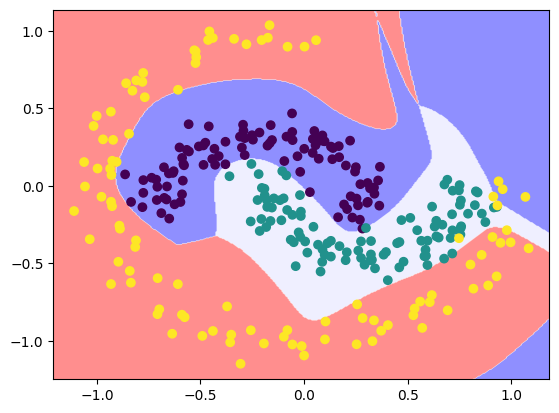

In [26]:
model.eval()
%matplotlib inline

### for plotting in 2d grid
ng = 400
_a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

with torch.no_grad():
    z = model(xyg)
    y = torch.argmax(classifier(z, hard=True), dim=1)
    
cf = plt.contourf(xg, yg, y.reshape(xg.shape),# v,
                     alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, marker='o', c=yy.reshape(-1))

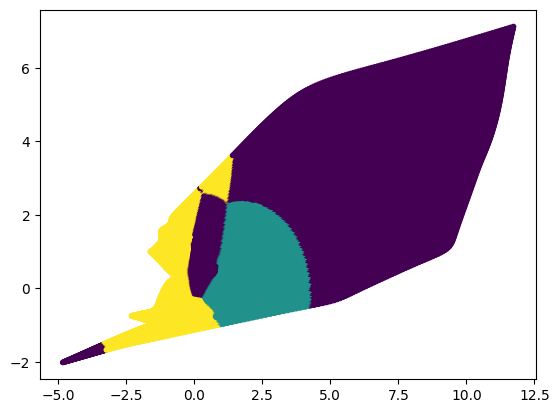

In [27]:
plt.scatter(z[:,0], z[:,1], marker='.', c=y.reshape(-1))   